In [21]:
import os
import re
import json
from glob import glob

import pandas as pd
import numpy as np
from ase.io import read, write
from ase.io.espresso import read_espresso_out
from tqdm import tqdm
from pprint import pprint

from sctk.materials import Material

In [38]:
CLEANED_SUPERCON_V2_CSV = './data/Supercon-master/supercon2_cleaned.csv'
CLEANED_SUPERCON_V1_CSV = './data/Supercon-master/supercon1_cleaned.csv'

SC_DATA_DIRS = [
    './data/sctk_structures/known',
    './data/sctk_structures/defect',
    './data/sctk_structures/known_v1',
    './data/sctk_structures/defect_v1',
]

SC_RELAXED_DATA_DIRS = [
    './data/sctk_structures/relaxed'
]

SC_RANDOM_DATA_DIR = './data/sctk_structures/random'
SC_RANDOM_DATA_INDEX = './data/sctk_structures/random/random_materials_dataset.csv'

ALIGNN_REGRESSION_DATA_EXPORT_DIR = './data/sctk_structures/alignn_sc_regression_data'
ALIGNN_CLASSIFIER_DATA_EXPORT_DIR = './data/sctk_structures/alignn_sc_classifier_data'

PROP_FILENAME = 'id_prop.csv'


In [39]:
ALIGNN_CONFIG_FILENAME = 'config.json'
DEFAULT_ALIGNN_CONFIG = {
    "version": "112bbedebdaecf59fb18e11c929080fb2f358246",
    "dataset": "user_data",
    "target": "target",
    "atom_features": "cgcnn",
    "neighbor_strategy": "k-nearest",
    "id_tag": "jid",
    "random_seed": 123,
    "classification_threshold": None,
    "n_val": None,
    "n_test": None,
    "n_train": None,
    "train_ratio": 0.8,
    "val_ratio": 0.1,
    "test_ratio": 0.1,
    "target_multiplication_factor": None,
    "epochs": 3,
    "batch_size": 2,
    "weight_decay": 1e-05,
    "learning_rate": 0.001,
    "filename": "sample",
    "warmup_steps": 2000,
    "criterion": "mse",
    "optimizer": "adamw",
    "scheduler": "onecycle",
    "pin_memory": False,
    "save_dataloader": False,
    "write_checkpoint": True,
    "write_predictions": True,
    "store_outputs": True,
    "progress": True,
    "log_tensorboard": False,
    "standard_scalar_and_pca": False,
    "use_canonize": True,
    "num_workers": 0,
    "cutoff": 8.0,
    "max_neighbors": 12,
    "keep_data_order": False,
    "model": {
        "name": "alignn",
        "alignn_layers": 4,
        "gcn_layers": 4,
        "atom_input_features": 92,
        "edge_input_features": 80,
        "triplet_input_features": 40,
        "embedding_features": 64,
        "hidden_features": 256,
        "output_features": 1,
        "link": "identity",
        "zero_inflated": False,
        "classification": False
    }
}

In [40]:
def verify_metadata(metadata):
    
    if not metadata or 'Tc (K)' not in metadata or np.isnan(metadata['Tc (K)']):
        return False
    
    # correct unlisted pressure in high-Tc Hydrides:
    if metadata['Tc (K)'] > 140 and metadata['Pressure (GPa)'] <= 1e-5:
        if 'Hydrides' in metadata['Classes']:
            metadata['Pressure (GPa)'] = 170.0
            metadata['Tags']['applied_pressure'] = True
        else:
            return False
        
    elif metadata['Tc (K)'] > 40 and metadata['Pressure (GPa)'] <= 1e-5 and \
        len(set(metadata['Classes']) & \
            {'Cuprates', 'Hydrides', 'Iron-chalcogenides', 'Iron-pnictides'}) == 0:
        return False
    
    return True
    

def export_regression_data(export_dir, metadatas_fn, alignn_config):
    
    sc_relaxed_map = {}
    dataset = {}
    
    # generate index of quantum espresso outputs:
    for sc_relaxed_dir in SC_RELAXED_DATA_DIRS:
        print(f'Indexing espresso output files in {sc_relaxed_dir}...')
        for result_dir in tqdm(os.listdir(sc_relaxed_dir)):
            pwo_dir = os.path.join(sc_relaxed_dir,result_dir)
            if not os.path.isdir(pwo_dir):
                continue
            pwo_file = os.path.join(pwo_dir, 'espresso.pwo')
            key = result_dir.split('_')[0]
            if key not in sc_relaxed_map:
                sc_relaxed_map[key] = []

            potential_energy = 0.0
            if os.path.isfile(pwo_file):
                with open(pwo_file,'r') as f:
                    # choose the best atoms with lowest PE during relaxation:
                    atoms_list = list(read_espresso_out(f,index=slice(None,-1)))
                    if atoms_list and len(atoms_list) > 0:
                        atoms = min(atoms_list, key=lambda a : a.get_potential_energy())
                        potential_energy = atoms.get_potential_energy()
                        sc_relaxed_map[key].append((potential_energy, atoms))

    # sort map of relaxed structures by potential energy:
    for k, v in sc_relaxed_map.items():
        v.sort()
    
    # generate dataset:
    for sc_dir in SC_DATA_DIRS:
        print(f'Indexing structures in {sc_dir}...')
        poscar_files = glob(os.path.join(sc_dir, '*.poscar'))
        for filepath in tqdm(poscar_files):
            
            json_filepaths = glob(os.path.splitext(filepath)[0] + '*.json')
            filename = os.path.split(filepath)[-1]
            key = os.path.splitext(filename)[0].split('_')[0]
            
            if json_filepaths and key not in dataset:
                # get relaxed structure (if found):
                if key in sc_relaxed_map and sc_relaxed_map[key]:
                    atoms = sc_relaxed_map[key][1]
                else:
                    atoms = read(filepath)
                
                # add key to dataset:
                dataset[key] = (atoms, [])
            
            # parse metadatas:
            for json_filepath in json_filepaths:
                with open(json_filepath) as f:
                    metadata = json.load(f)
                    if verify_metadata(metadata):
                        dataset[key][1].append(metadata)
            
    # generate list of prediction values:
    dataset_y = {}
    print('Generating prediction values...')
    for key, (atoms, metadatas) in tqdm(dataset.items()):
        if metadatas:
            y_values = metadatas_fn(metadatas)
            dataset_y[key] = y_values
        
    
    # export properties:
    print(f'Exporting dataset to {export_dir}...')
    for key, (atoms, metadatas) in tqdm(dataset.items()):
        if metadatas:
            export_file = key + '.poscar'
            export_filepath = os.path.join(export_dir, export_file)
            atoms.write(export_filepath)
        
    # write properties file:
    prop_csv_path = os.path.join(export_dir, PROP_FILENAME)
    with open(prop_csv_path, 'w') as f:
        for key, y_values in dataset_y.items():
            export_file = key + '.poscar'
            f.write(', '.join((export_file,) + 
                              tuple(str(y) for y in y_values)) + '\n')
    print(f'Saved properties to {prop_csv_path}')
    
    # copy alignn_config values:
    config_filepath = os.path.join(export_dir, ALIGNN_CONFIG_FILENAME)
    with open(config_filepath, 'w') as f:
        json.dump(alignn_config, f, indent=4)
    
    return dataset, dataset_y

In [42]:
def get_tc_values(metadatas):
    
    tcs = np.array([ m['Tc (K)'] for m in metadatas ])
    
    #fit data to gamma distribution:
    # (kappa ~ E[x]/theta, theta ~ E[xln(x)] - E[x]E[ln(x)])
    mu = np.mean(tcs)
    theta = 1./np.mean(tcs)
    if len(tcs) > 1:
        theta = max(1e-5,np.mean(tcs*np.log(tcs)) - np.mean(tcs)*np.mean(np.log(tcs)))
        
    return mu, theta


config = DEFAULT_ALIGNN_CONFIG.copy()
config['model']['output_features'] = 2

print('Using ALIGNN configuration:')
pprint(config)

dataset, dataset_y = export_regression_data(ALIGNN_REGRESSION_DATA_EXPORT_DIR, get_tc_values, config)

Using ALIGNN configuration:
{'atom_features': 'cgcnn',
 'batch_size': 2,
 'classification_threshold': None,
 'criterion': 'mse',
 'cutoff': 8.0,
 'dataset': 'user_data',
 'epochs': 3,
 'filename': 'sample',
 'id_tag': 'jid',
 'keep_data_order': False,
 'learning_rate': 0.001,
 'log_tensorboard': False,
 'max_neighbors': 12,
 'model': {'alignn_layers': 4,
           'atom_input_features': 92,
           'classification': False,
           'edge_input_features': 80,
           'embedding_features': 64,
           'gcn_layers': 4,
           'hidden_features': 256,
           'link': 'identity',
           'name': 'alignn',
           'output_features': 2,
           'triplet_input_features': 40,
           'zero_inflated': False},
 'n_test': None,
 'n_train': None,
 'n_val': None,
 'neighbor_strategy': 'k-nearest',
 'num_workers': 0,
 'optimizer': 'adamw',
 'pin_memory': False,
 'progress': True,
 'random_seed': 123,
 'save_dataloader': False,
 'scheduler': 'onecycle',
 'standard_scalar_

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 28.83it/s]


Indexing structures in ./data/sctk_structures/known...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1111/1111 [00:25<00:00, 43.15it/s]


Indexing structures in ./data/sctk_structures/defect...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 164.53it/s]


Indexing structures in ./data/sctk_structures/known_v1...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1201/1201 [00:06<00:00, 190.35it/s]


Indexing structures in ./data/sctk_structures/defect_v1...


0it [00:00, ?it/s]


Generating prediction values...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2028/2028 [00:00<00:00, 23483.88it/s]


Exporting dataset to ./data/sctk_structures/alignn_sc_regression_data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2028/2028 [00:01<00:00, 1256.60it/s]

Saved properties to ./data/sctk_structures/alignn_sc_regression_data/id_prop.csv


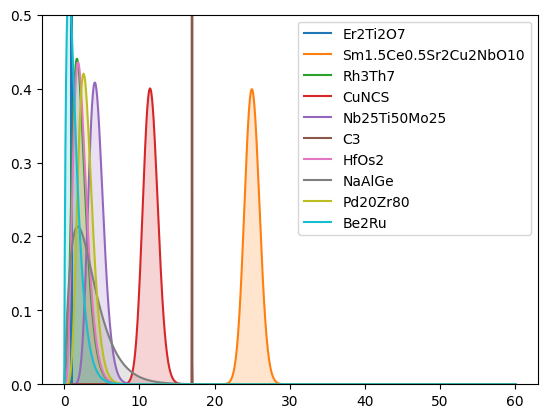

In [43]:
from scipy.stats import gamma
import random
import matplotlib.pyplot as plt

plt.figure()
for _ in range(10):
    (key, (mu,theta)) = random.choice(list(dataset_y.items()))
    #print(key, mu, theta)
    #print(gamma.var(a=mu/theta, scale=theta))
    x = np.linspace(0,60, 2000)
    y = gamma.pdf(x,a=mu/theta, scale=theta)
    plt.plot(x,y,label=key)
    plt.fill_between(x,y, alpha=0.2)

plt.ylim((0,0.5))
plt.legend()
plt.show()

In [44]:
id_prop_file = os.path.join(ALIGNN_REGRESSION_DATA_EXPORT_DIR, PROP_FILENAME)
id_prop_df = pd.read_csv(id_prop_file, names=['formula','Tc','Theta'])

id_prop_df

,formula,Tc,Theta
0,(Ba)Fe2As2.poscar,39.000000,0.000010
1,(Sr)Fe2As2.poscar,39.000000,0.000010
2,Ag.poscar,18.671053,24.253210
3,Ag2O2.poscar,35.000000,0.028571
4,Ag5Pb2O6.poscar,0.225100,0.181498
...,...,...,...
1882,HfRh.poscar,1.007500,0.020291
1883,HfRhSi.poscar,1.150000,0.869565
1884,HfRuAs.poscar,3.193333,0.313152
1885,HfRuP.poscar,11.796667,0.084770


In [71]:
def export_classifier_data(export_dir, 
                           alignn_config,
                           random_data_index=None,
                           class_metadata_fn=None,
                           threshold=0,
                           random_in_support=True):
    
    sc_relaxed_map = {}
    dataset = {}
    random_dataset = {}
    
    # generate index of quantum espresso outputs:
    for sc_relaxed_dir in SC_RELAXED_DATA_DIRS:
        print(f'Indexing espresso output files in {sc_relaxed_dir}...')
        for result_dir in tqdm(os.listdir(sc_relaxed_dir)):
            pwo_dir = os.path.join(sc_relaxed_dir,result_dir)
            if not os.path.isdir(pwo_dir):
                continue
            pwo_file = os.path.join(pwo_dir, 'espresso.pwo')
            key = result_dir.split('_')[0]
            if key not in sc_relaxed_map:
                sc_relaxed_map[key] = []
            
            potential_energy = 0.0
            if os.path.isfile(pwo_file):
                with open(pwo_file,'r') as f:
                    # choose the best atoms with lowest PE during relaxation:
                    atoms_list = list(read_espresso_out(f,index=slice(None,-1)))
                    if atoms_list and len(atoms_list) > 0:
                        atoms = min(atoms_list, key=lambda a : a.get_potential_energy())
                        potential_energy = atoms.get_potential_energy()
                        sc_relaxed_map[key].append((potential_energy, atoms))
    
    # sort map of relaxed structures by potential energy:
    for k, v in sc_relaxed_map.items():
        v.sort()
    
    # generate dataset:
    for sc_dir in SC_DATA_DIRS:
        print(f'Indexing structures in {sc_dir}...')
        poscar_files = glob(os.path.join(sc_dir, '*.poscar'))
        for filepath in tqdm(poscar_files):
            
            json_filepaths = glob(os.path.splitext(filepath)[0] + '*.json')
            filename = os.path.split(filepath)[-1]
            key = os.path.splitext(filename)[0].split('_')[0]
            
            if json_filepaths and key not in dataset:
                # get relaxed structure (if found):
                if key in sc_relaxed_map and sc_relaxed_map[key]:
                    atoms = sc_relaxed_map[key][1]
                else:
                    atoms = read(filepath)
                
                # add key to dataset:
                dataset[key] = (atoms, [])
            
            # parse metadatas:
            for json_filepath in json_filepaths:
                with open(json_filepath) as f:
                    metadata = json.load(f)
                    if verify_metadata(metadata):
                        dataset[key][1].append(metadata)
            
    # parse all random structures:
    random_data_df = pd.read_csv(random_data_index)
    for i, row in random_data_df.iterrows():
        
        key = row['formula']
        poscar_file = os.path.join(SC_RANDOM_DATA_DIR, row['mp_id'] + '.poscar')
        in_support = (float(row['support']) > 0.0)
        if in_support or random_in_support:
            assert(os.path.exists(poscar_file))
            atoms = read(poscar_file)
            random_dataset[key] = atoms
              
    # generate list of prediction values:
    dataset_y = {}
    
    print('Generating prediction values...')
    for key, (atoms, metadatas) in tqdm(dataset.items()):
        if metadatas:
            dataset_y[key] = threshold + 1.0
    for key, atoms in tqdm(random_dataset.items()):
        if key not in dataset_y:
            dataset_y[key] = threshold - 1.0
    
    # export properties:
    print(f'Exporting dataset to {export_dir}...')
    for key, (atoms, metadatas) in tqdm(dataset.items()):
        if metadatas:
            export_file = key + '.poscar'
            export_filepath = os.path.join(export_dir, export_file)
            atoms.write(export_filepath)
    for key, atoms in tqdm(random_dataset.items()):
        export_file = key + '.poscar'
        export_filepath = os.path.join(export_dir, export_file)
        atoms.write(export_filepath)
    
    # write properties file:
    prop_csv_path = os.path.join(export_dir, PROP_FILENAME)
    with open(prop_csv_path, 'w') as f:
        for key, y_value in dataset_y.items():
            export_file = key + '.poscar'
            f.write(', '.join([export_file.strip(), str(y_value)]) + '\n')
    print(f'Saved properties to {prop_csv_path}')
    
    # copy alignn_config values (set to classification):
    config_filepath = os.path.join(export_dir, ALIGNN_CONFIG_FILENAME)
    alignn_config['model']['classification']=True
    with open(config_filepath, 'w') as f:
        json.dump(alignn_config, f, indent=4)
    
    return dataset, dataset_y


In [85]:
config = DEFAULT_ALIGNN_CONFIG.copy()
config['model']['classification'] = True

print('Using ALIGNN configuration:')
pprint(config)

dataset, dataset_y = export_classifier_data(ALIGNN_CLASSIFIER_DATA_EXPORT_DIR,
                                            config,
                                            SC_RANDOM_DATA_INDEX)

Using ALIGNN configuration:
{'atom_features': 'cgcnn',
 'batch_size': 2,
 'classification_threshold': None,
 'criterion': 'mse',
 'cutoff': 8.0,
 'dataset': 'user_data',
 'epochs': 3,
 'filename': 'sample',
 'id_tag': 'jid',
 'keep_data_order': False,
 'learning_rate': 0.001,
 'log_tensorboard': False,
 'max_neighbors': 12,
 'model': {'alignn_layers': 4,
           'atom_input_features': 92,
           'classification': True,
           'edge_input_features': 80,
           'embedding_features': 64,
           'gcn_layers': 4,
           'hidden_features': 256,
           'link': 'identity',
           'name': 'alignn',
           'output_features': 2,
           'triplet_input_features': 40,
           'zero_inflated': False},
 'n_test': None,
 'n_train': None,
 'n_val': None,
 'neighbor_strategy': 'k-nearest',
 'num_workers': 0,
 'optimizer': 'adamw',
 'pin_memory': False,
 'progress': True,
 'random_seed': 123,
 'save_dataloader': False,
 'scheduler': 'onecycle',
 'standard_scalar_a

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 27.99it/s]


Indexing structures in ./data/sctk_structures/known...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1111/1111 [00:24<00:00, 45.14it/s]


Indexing structures in ./data/sctk_structures/defect...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 153.85it/s]


Indexing structures in ./data/sctk_structures/known_v1...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1201/1201 [00:06<00:00, 176.52it/s]


Indexing structures in ./data/sctk_structures/defect_v1...


0it [00:00, ?it/s]


Generating prediction values...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10182/10182 [00:00<00:00, 1116478.09it/s]


Exporting dataset to ./data/sctk_structures/alignn_sc_classifier_data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2028/2028 [00:01<00:00, 1300.21it/s]


Saved properties to ./data/sctk_structures/alignn_sc_classifier_data/id_prop.csv


In [86]:
id_prop_file = os.path.join(ALIGNN_CLASSIFIER_DATA_EXPORT_DIR, PROP_FILENAME)
id_prop_df = pd.read_csv(id_prop_file, names=['formula','Superconductor'])

print('# Superconductors:', len(id_prop_df[id_prop_df['Superconductor'] > 0.0]))
print('# Non-Superconductors:',len(id_prop_df[id_prop_df['Superconductor'] < 0.0]))

# Superconductors: 1887
# Non-Superconductors: 10182


In [87]:
for formula in id_prop_df['formula']:
    file_path = os.path.join(ALIGNN_CLASSIFIER_DATA_EXPORT_DIR,formula+'.poscar')
    if not os.path.isfile(file_path):
        print(formula, file_path)

(Ba)Fe2As2.poscar ./data/sctk_structures/alignn_sc_classifier_data/(Ba)Fe2As2.poscar.poscar
(Sr)Fe2As2.poscar ./data/sctk_structures/alignn_sc_classifier_data/(Sr)Fe2As2.poscar.poscar
Ag.poscar ./data/sctk_structures/alignn_sc_classifier_data/Ag.poscar.poscar
Ag2O2.poscar ./data/sctk_structures/alignn_sc_classifier_data/Ag2O2.poscar.poscar
Ag5Pb2O6.poscar ./data/sctk_structures/alignn_sc_classifier_data/Ag5Pb2O6.poscar.poscar
AgAlO2.poscar ./data/sctk_structures/alignn_sc_classifier_data/AgAlO2.poscar.poscar
FeTe.poscar ./data/sctk_structures/alignn_sc_classifier_data/FeTe.poscar.poscar
InTaS2.poscar ./data/sctk_structures/alignn_sc_classifier_data/InTaS2.poscar.poscar
Ir.poscar ./data/sctk_structures/alignn_sc_classifier_data/Ir.poscar.poscar
Ir2Ga9.poscar ./data/sctk_structures/alignn_sc_classifier_data/Ir2Ga9.poscar.poscar
Ir3Te8.poscar ./data/sctk_structures/alignn_sc_classifier_data/Ir3Te8.poscar.poscar
IrGe.poscar ./data/sctk_structures/alignn_sc_classifier_data/IrGe.poscar.posca

 W2O5.poscar ./data/sctk_structures/alignn_sc_classifier_data/ W2O5.poscar.poscar
 Bi2O5.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Bi2O5.poscar.poscar
 Ni2O3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Ni2O3.poscar.poscar
 UIr3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ UIr3.poscar.poscar
 Sb3O7.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Sb3O7.poscar.poscar
 Ni2P2O9.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Ni2P2O9.poscar.poscar
 K5La2.poscar ./data/sctk_structures/alignn_sc_classifier_data/ K5La2.poscar.poscar
 LiY2Co.poscar ./data/sctk_structures/alignn_sc_classifier_data/ LiY2Co.poscar.poscar
 Zr2TcPt.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Zr2TcPt.poscar.poscar
 AlReTc2.poscar ./data/sctk_structures/alignn_sc_classifier_data/ AlReTc2.poscar.poscar
 Be2IrRu.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Be2IrRu.poscar.poscar
 Nb2MoRh.poscar ./data/sctk_structures/alignn_sc_classifier_da

 DyAs.poscar ./data/sctk_structures/alignn_sc_classifier_data/ DyAs.poscar.poscar
 SrC2.poscar ./data/sctk_structures/alignn_sc_classifier_data/ SrC2.poscar.poscar
 GdMg.poscar ./data/sctk_structures/alignn_sc_classifier_data/ GdMg.poscar.poscar
 Ti3Cu4.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Ti3Cu4.poscar.poscar
 YbBH4.poscar ./data/sctk_structures/alignn_sc_classifier_data/ YbBH4.poscar.poscar
 GaN.poscar ./data/sctk_structures/alignn_sc_classifier_data/ GaN.poscar.poscar
 InO.poscar ./data/sctk_structures/alignn_sc_classifier_data/ InO.poscar.poscar
 NaZnBi.poscar ./data/sctk_structures/alignn_sc_classifier_data/ NaZnBi.poscar.poscar
 Bi2Te2O.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Bi2Te2O.poscar.poscar
 MoP2.poscar ./data/sctk_structures/alignn_sc_classifier_data/ MoP2.poscar.poscar
 RuCl3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ RuCl3.poscar.poscar
 LaH20.poscar ./data/sctk_structures/alignn_sc_classifier_data/ LaH20.poscar.poscar


 Pa3Re.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Pa3Re.poscar.poscar
 SmEr3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ SmEr3.poscar.poscar
 LuUO3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ LuUO3.poscar.poscar
 LuAl3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ LuAl3.poscar.poscar
 Ga3Te.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Ga3Te.poscar.poscar
 K3Sm.poscar ./data/sctk_structures/alignn_sc_classifier_data/ K3Sm.poscar.poscar
 LuTh3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ LuTh3.poscar.poscar
 Hg3As.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Hg3As.poscar.poscar
 HgI3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ HgI3.poscar.poscar
 K3Sn.poscar ./data/sctk_structures/alignn_sc_classifier_data/ K3Sn.poscar.poscar
 K3Sr.poscar ./data/sctk_structures/alignn_sc_classifier_data/ K3Sr.poscar.poscar
 GeBi3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ GeBi3.poscar.poscar


 Ir3Se8.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Ir3Se8.poscar.poscar
 FeSbAs.poscar ./data/sctk_structures/alignn_sc_classifier_data/ FeSbAs.poscar.poscar
 SnBrCl.poscar ./data/sctk_structures/alignn_sc_classifier_data/ SnBrCl.poscar.poscar
 ScClO.poscar ./data/sctk_structures/alignn_sc_classifier_data/ ScClO.poscar.poscar
 Te3As2.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Te3As2.poscar.poscar
 Na2Cl.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Na2Cl.poscar.poscar
 Ba2Sb.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Ba2Sb.poscar.poscar
 LiBeP.poscar ./data/sctk_structures/alignn_sc_classifier_data/ LiBeP.poscar.poscar
 LiGe.poscar ./data/sctk_structures/alignn_sc_classifier_data/ LiGe.poscar.poscar
 ZrS3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ ZrS3.poscar.poscar
 HfS3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ HfS3.poscar.poscar
 CaRhF6.poscar ./data/sctk_structures/alignn_sc_classifier_data/ CaRhF6.po

 Sm4ZrFe33.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Sm4ZrFe33.poscar.poscar
 SbAs.poscar ./data/sctk_structures/alignn_sc_classifier_data/ SbAs.poscar.poscar
 SbTeRh.poscar ./data/sctk_structures/alignn_sc_classifier_data/ SbTeRh.poscar.poscar
 SbTe.poscar ./data/sctk_structures/alignn_sc_classifier_data/ SbTe.poscar.poscar
 RuW.poscar ./data/sctk_structures/alignn_sc_classifier_data/ RuW.poscar.poscar
 SbAsRh.poscar ./data/sctk_structures/alignn_sc_classifier_data/ SbAsRh.poscar.poscar
 Sb6O13.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Sb6O13.poscar.poscar
 SbPb4.poscar ./data/sctk_structures/alignn_sc_classifier_data/ SbPb4.poscar.poscar
 RhO3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ RhO3.poscar.poscar
 ReW3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ ReW3.poscar.poscar
 RuRh.poscar ./data/sctk_structures/alignn_sc_classifier_data/ RuRh.poscar.poscar
 Ce5Ge4.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Ce5Ge4.posc

 Er3Rh.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Er3Rh.poscar.poscar
 HfGa2.poscar ./data/sctk_structures/alignn_sc_classifier_data/ HfGa2.poscar.poscar
 Zr3NbZn8.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Zr3NbZn8.poscar.poscar
 Zn3CdO4.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Zn3CdO4.poscar.poscar
 YbLuB24.poscar ./data/sctk_structures/alignn_sc_classifier_data/ YbLuB24.poscar.poscar
 Zr3AlN4.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Zr3AlN4.poscar.poscar
 YbGaCu4.poscar ./data/sctk_structures/alignn_sc_classifier_data/ YbGaCu4.poscar.poscar
 YbCdAg.poscar ./data/sctk_structures/alignn_sc_classifier_data/ YbCdAg.poscar.poscar
 YUSb2.poscar ./data/sctk_structures/alignn_sc_classifier_data/ YUSb2.poscar.poscar
 Zn2Pd.poscar ./data/sctk_structures/alignn_sc_classifier_data/ Zn2Pd.poscar.poscar
 YbDyS3.poscar ./data/sctk_structures/alignn_sc_classifier_data/ YbDyS3.poscar.poscar
 Zn10Fe3.poscar ./data/sctk_structures/alignn_sc_c